#**Binary Classification Model**

In [1]:
# Import files BinaryTrain and BinaryTest
from google.colab import files

uploaded1 = files.upload()
uploaded2 = files.upload()


Saving BinaryTrain to BinaryTrain (4)


Saving BinaryTest to BinaryTest (4)


##Importing Necessary Libraries

In [2]:
# Importing all the libraries needed
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd



## Load the Dataset


In [3]:
# check if CUDA is available if not then use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the binary train and test datasets
train_df = pd.read_csv("BinaryTrain")
test_df = pd.read_csv("BinaryTest")

# Checking the dataset size
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

#Displaying  first 5 rows of training dataset
print(train_df.head())
print(test_df.head())


Train set shape: (7899, 8)
Test set shape: (2101, 8)
   UDI Type  Air_temperature_K  Process_Temperature  Rotational_Speed_rpm  \
0  918    L              295.3                305.7                  1475   
1  919    M              295.3                305.7                  1473   
2  917    M              295.3                305.8                  1589   
3  915    M              295.4                305.9                  1518   
4  931    M              295.5                305.9                  1453   

   Torque_Nm  Tool_Wear_min  Target  
0       51.0            187       0  
1       38.5            189       0  
2       36.2            184       0  
3       40.6            178       0  
4       47.3              9       0  
   UDI Type  Air_temperature_K  Process_Temperature  Rotational_Speed_rpm  \
0  920    L              295.4                305.8                  1407   
1  916    M              295.4                305.8                  1526   
2  932    L              

##Additional Preprocessing Steps

In [4]:



le = LabelEncoder()

# Label encode Type column L=0, M=1, H=2
train_df["Type"] = le.fit_transform(train_df["Type"])
test_df["Type"] = le.transform(test_df["Type"])

# Splitting up the traget from the features
X_train = train_df.drop(columns=["Target"])
y_train = train_df["Target"]
X_test = test_df.drop(columns=["Target"])
y_test = test_df["Target"]

# Normalize numeric features using StandardScalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##Define Custom Dataset

In [5]:
class BinaryMaintenanceDataset(Dataset):

    # constructor
    def __init__(self, features, labels):
        # converts features from Numpy format to Pytorch FloatTensor
        self.X = torch.tensor(features, dtype=torch.float32)

        #
        self.y = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    # Tells Pytorch the length of the dataset
    def __len__(self):
        return len(self.X)

    # Allows Dataset to bahave like a list (allows batching to work)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Creating dataset objects
train_dataset = BinaryMaintenanceDataset(X_train_scaled, y_train)
test_dataset = BinaryMaintenanceDataset(X_test_scaled, y_test)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Defining Model Architecture

In [6]:

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            # Input layer with 16 neurons
            nn.Linear(input_size, 16),
            nn.ReLU(),

            # Hidden layer with 8 neurons and ReLU activation
            nn.Linear(16, 8),
            nn.ReLU(),

            # 1 output node for binary classification
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)


## Initialize The Model

In [7]:
# Getting number of input features
input_dim = X_train_scaled.shape[1]

# Creating model
model = BinaryClassifier(input_size=input_dim)

# Moving model to device
model = model.to(device)


## Loss Function and Optimizer

In [8]:
# Binary cross entropy with logits as loss fucntion and Adam as optimizer with learning rate of 0.001
LossF = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training The Model

In [9]:
# set at 100 epochs
epochs = 100

for epoch in range(epochs):
    model.train()  # Set model to training model
    total_loss = 0 # track loss for each epoch

    for X_batch, y_batch in train_loader:
        # moving data to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad() # clearing previous gradients
        outputs = model(X_batch) # Forward pass
        loss = LossF(outputs, y_batch) # Calculating loss
        loss.backward() # Back propagation
        optimizer.step() #updating weights

        total_loss += loss.item()

    # Print loss at each epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 73.8208
Epoch 2, Loss: 35.5958
Epoch 3, Loss: 31.1487
Epoch 4, Loss: 27.9282
Epoch 5, Loss: 25.6414
Epoch 6, Loss: 24.1645
Epoch 7, Loss: 23.4251
Epoch 8, Loss: 22.9454
Epoch 9, Loss: 22.6643
Epoch 10, Loss: 22.3324
Epoch 11, Loss: 22.1209
Epoch 12, Loss: 21.8458
Epoch 13, Loss: 21.7554
Epoch 14, Loss: 21.6216
Epoch 15, Loss: 21.3738
Epoch 16, Loss: 21.2974
Epoch 17, Loss: 21.2096
Epoch 18, Loss: 20.9446
Epoch 19, Loss: 20.7353
Epoch 20, Loss: 20.6020
Epoch 21, Loss: 20.3490
Epoch 22, Loss: 20.0617
Epoch 23, Loss: 19.8224
Epoch 24, Loss: 19.5347
Epoch 25, Loss: 19.5611
Epoch 26, Loss: 19.2856
Epoch 27, Loss: 19.0894
Epoch 28, Loss: 18.9516
Epoch 29, Loss: 18.7432
Epoch 30, Loss: 18.4156
Epoch 31, Loss: 18.2744
Epoch 32, Loss: 17.9438
Epoch 33, Loss: 17.7304
Epoch 34, Loss: 17.4127
Epoch 35, Loss: 17.2006
Epoch 36, Loss: 16.9897
Epoch 37, Loss: 16.7199
Epoch 38, Loss: 16.5286
Epoch 39, Loss: 16.1961
Epoch 40, Loss: 16.1612
Epoch 41, Loss: 15.9688
Epoch 42, Loss: 15.7709
E

## Evaluation

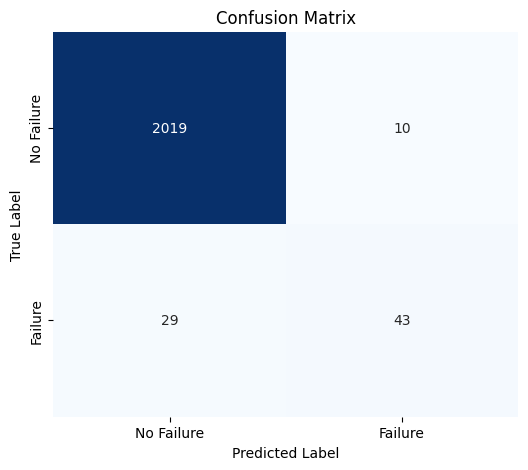


Classification Report:

              precision    recall  f1-score   support

  No Failure       0.99      1.00      0.99      2029
     Failure       0.81      0.60      0.69        72

    accuracy                           0.98      2101
   macro avg       0.90      0.80      0.84      2101
weighted avg       0.98      0.98      0.98      2101



In [10]:
# setting to evaluation mode
model.eval()
all_preds, all_labels = [], []

# no grad for faster evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch) # Forward pass
        preds = (torch.sigmoid(outputs) > 0.5).float() # Converting logits to binary
        all_preds.append(preds.cpu()) # Move to CPU for stacking
        all_labels.append(y_batch.cpu())

# Stack results
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Failure", "Failure"],
            yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print performance metrics
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["No Failure", "Failure"]))